# My own mixture of Gaussians

In [ ]:
import numpy as np
from matplotlib.patches import Ellipse
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import permutations
from pandas import Series, DataFrame
import pandas as pd
'''
kkk=가우시안 분포 갯수(class 갯수),NUM=class당 데이타 갯수
평균과 분산을 입력해 주면 여러개의 가우시안 분포가 생성되고 , 생성된 데이터를 모두 모아서 Mixture of Gaussian을 만들었다. 
'''
def Gausion_Mixture(kkk,NUM,Means,COVS): 
  qqq=[]
  for i in range(kkk):
    mean,cov,num_data=Means[i],COVS[i],NUM[i]
    x, y = np.random.multivariate_normal(mean, cov, num_data).T
    plt.scatter(x, y)
    plt.scatter(Means[i][0],Means[i][1],c='r',marker='x',s=50)
    qwe= np.stack((x,y), axis=1)
    qqq.append(qwe)
    
  plt.axis('equal')
  plt.title("Original distribution")
  plt.show()
  ma=20
  X=np.zeros((ma,2))
  
  Alphas=[]
  for i in range(len(NUM)):
    Alphas.append(NUM[i]/sum(NUM))
  for kk in range(kkk):
    X=np.concatenate((X,qqq[kk]),axis=0)
  X=X[ma:,:]
  print("")
  print("원래분포")
  print("mean")
  print(np.matrix(Means))
  print("")
  print("coVariance")
  print(np.array(COVS))  
  print("")
  print("alpha")
  print(np.array(Alphas).round(2))
  return X # mixture of Gaussian 의 x,y 좌표를 반환한다.

#EM algotirthm

In [ ]:
class EM(object):
    def __init__(self, X, k):
        self.data = X # data는 x,y좌표 담은거.
        self.m, self.n = X.shape # (data수=150개, n=2d)
        self.k = k #가우시안 분포 수 (class 수=5) 
        
    def _init(self):
        #초기값(아무렇게 shape만 맞춰서)

        #평균
        self.mean_arr = 10*np.asmatrix(np.random.random((self.k, self.n))) #(5,2) 랜덤 메트릭스 생성
        #분산
        self.sigma_arr = 10*np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)]) # identity :행렬(2,2) 3개
        # mixing parameters -각 클래스일 확률
        self.alpha = np.ones(self.k)/self.k 
        #w: 각 데이터가 각 클래스일 확률을 담은 메트릭스
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float)) #(150,5) 원소 0 메트릭스
        
    def fit(self):
        self._init()
        #초기값에 따라 지역해에 빠질수도 있다. 따라서 clustering이 잘 안될 때도 있다. 
        Loglikes=[]
        Num=[]
        #threshold
        epsilon=1e-5 # 충분히 작은 숫자 
        iters = 0 #몇 번 도는지 초기값 
        loglike = 1 #loglikelihood 초기값 
        previous_loglike = 0
        while(loglike-previous_loglike > epsilon): #loglikelihood가 epsilon보다 더 증가될동안 반복.
            previous_loglike = self.loglikelihood() # 이전 loglikelihood 구하고
            self.e_step() # 
            self.m_step() # 
            iters += 1 # iteration 횟수 업데이트 
            loglike = self.loglikelihood() #현재 loglikelihood 업데이트
            Loglikes.append(loglike)
            Num.append(iters)
            if iters % 5==0:
              print('Iteration %d: log-likelihood is %.6f'%(iters, loglike))
        plt.plot(Num,Loglikes)
        plt.xlabel('Iteration')
        plt.ylabel('Loglikelihood')
        print("")
        print('%d-th쯤되면 loglikelihood 변화없네,log-likelihood is %.6f'%(iters, loglike))
        return self.w
    def loglikelihood(self):
        loglike = 0 #loglikelihood 초기값
        for i in range(self.m): #data 갯수 만큼 150개
            possib = 0 
            for j in range(self.k): #class 수=5 만큼 
                possib =possib+ sp.stats.multivariate_normal.pdf(self.data[i], # 150개 data에 대해서
                                                        self.mean_arr[j].A1, #각 class의 평균 
                                                        self.sigma_arr[j]) *self.alpha[j] #위의 pdf 값에다가 각 클래스별 확률을 곱한다.
                #즉, j번째 parameter(평균,분산)을 봤을 때 i번째 data일 확률에 j 번째 클래스일 확률 alpha를 곱한 후,
                  
            loglike += np.log(possib) #log 씌운것을 모든 data에 대해서 더한다.
        return loglike
        
    def e_step(self): #이전의 parameter(theta)와 data를 보고 y_i의 확률을 구한다.(p(Y|X,theta(g)))
        
        for i in range(self.m): #data 갯수 150번 
            density = 0 #분모에 들어가는 
            for j in range(self.k): #k=5 각각의 class에 대해서 pdf 구한 후 
                num = sp.stats.multivariate_normal.pdf(self.data[i], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.alpha[j]

                density =density+ num # 다 더해 준 것이 분모로 들어감. 
                self.w[i, j] = num #각각의 pdf가 w 메트릭스로 들어감. 
            if density==0:
              density=1.1e-25 #density이 0이 될때를 대비해서 .
            self.w[i, :] =self.w[i, :]/ density   #  w:  p(Y|X,theta(g)) 구한거임.
        
            # w: 150개의 데이터가 각각의 class일 확률 
               
    def m_step(self):
        for j in range(self.k): #class 갯수만큼  
            const = self.w[:, j].sum() #j 클래스일 확률 150개 쭉 을 다더한 값. 분자 
            #alpha update
            self.alpha[j] = 1/self.m * const # 1/150 * const :j번째 클래스가 얼마나 등장할지 비율로 alpha를 정함.
            
            mu_j = np.zeros(self.n)
            sigma_j = np.zeros((self.n, self.n))
            #theta update
            for i in range(self.m):
                mu_j += (self.data[i, :] * self.w[i, j])
                sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = mu_j / const
            self.sigma_arr[j] = sigma_j / const

# EM을 통해 얻은 parameter 출력, 가우시안 분포 그리기, 

In [ ]:
def draw_optimized_gaussian(X,prediction,kkk):
  ax = plt.figure().add_subplot(1,1,1)
  plt.scatter(X[:, 0], X[:, 1], c=prediction, s=40, cmap='viridis')
  plt.axis('equal')
  new_mean=np.asarray(gmm.mean_arr)
  for i in range(kkk):
    plt.scatter(new_mean[i][0],new_mean[i][1],marker='x',c='r',s=50)
    
    w,v = np.linalg.eig(gmm.sigma_arr[i]) #분산 메트릭스의 고윳값, 고유벡터
    # We pick the largest eigen value
    order = w.argsort()[::-1] #오름차순 정렬하고 순서 거꾸로. :내림차순 
    w = w[order] 
    v = v[:,order]

    # we compute the angle towards the eigen vector with the largest eigen value
    degree = np.degrees(np.arctan(v[1,0]/v[0,0])) #degrees: 각도로 바꿔줌 ,arctan:아크탄젠트(역삼각함수)- 

    # Compute the width and height of the ellipse based on the eigen values (ie the length of the vectors)
    width, height = 2.5 * np.sqrt(w) #eigenvalue의 제곱근 
    
    ellip = Ellipse(xy=[new_mean[i][0],new_mean[i][1]], width=width, height=height, angle=degree)
    ellip.set_alpha(0.5)
    ellip.set_facecolor('r')
    ax.add_artist(ellip)
  print("After EM")
  print("mean")
  print(gmm.mean_arr.round(1))
  print("")
  print("coVariance")
  print(gmm.sigma_arr.round(1))  
  print("")
  print("alpha")
  print(gmm.alpha.round(1))
  print("")
  plt.title("After EM")
  plt.show()

# 클러스터링에 label 붙혀서 정확도 측정하기.
- E step 에서 구한 확률로 clustering 

In [ ]:
def clustering_label(W_p,kkk):
  prediction=[] #예측한 레이블.  
  COUNT=[]
  for i in range(len(W_p)):
    prediction.append(np.argmax(np.asarray(W_p)[i]))
  cclass=list(range(0,kkk))

  for cc in cclass:
    count=0
    for j in range(len(prediction)):
      if prediction[j]==cc:
        count+=1
          
    COUNT.append(count)
  #print("class별 갯수:",COUNT)
  #print("")
  #print("Clustering labels")
  return np.array(prediction)

def clustering_accuracy(W_p,NUM,kkk):
  #정답 라벨
  Label=np.array([])
  for i in range(kkk):
    z4=np.ones((NUM[i],))+(i-1)
    Label=np.concatenate((Label,z4),axis=0) 

  MACS=[]
  possible_wp=[]
  ppppp=[]
  for d in range(kkk):
    ppppp.append(W_p[:,d])
  for possible in permutations(ppppp, kkk):
      possible=np.array(possible).reshape(kkk,sum(NUM)).T
      possible=np.asmatrix(possible)
      possible_wp.append(possible)
      cluster_labels=clustering_label(possible,kkk)
      Clustering_predict =  Label==cluster_labels
      MACS.append(np.mean(Clustering_predict))
  
  cluster_labels=clustering_label(possible_wp[np.argmax(MACS)],kkk)
  print("clustering 된 라벨",cluster_labels)
  print("Clustering accuracy is ",round(max(MACS),3))
  return cluster_labels

# Experiment on various parameters

## Same spherical covariance
 

원래 분포


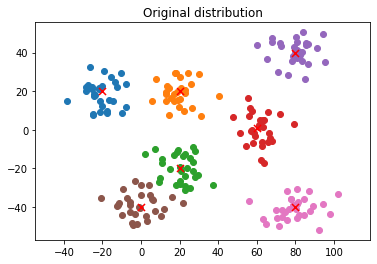


원래분포
mean
[[-20  20]
 [ 20  20]
 [ 20 -20]
 [ 60   1]
 [ 80  40]
 [  0 -40]
 [ 80 -40]]

coVariance
[[[50  0]
  [ 0 50]]

 [[50  0]
  [ 0 50]]

 [[50  0]
  [ 0 50]]

 [[50  0]
  [ 0 50]]

 [[50  0]
  [ 0 50]]

 [[50  0]
  [ 0 50]]

 [[50  0]
  [ 0 50]]]

alpha
[0.14 0.14 0.14 0.14 0.14 0.14 0.14]


In [ ]:
NUM= [30,30,30,30,30,30,30] #각 클래스 별 데이터 수. 
#NUM= [30,30,30,30,30]
kkk=len(NUM) #class 갯수
Means=[ #각 class의 평균
     [-20, 20],
     [20, 20],
     [20, -20],
     [60, 1],
     [80, 40],
     [0, -40],
     [80, -40]]
COVS=[ #각 클래스 분산 
        [[50, 0], [0, 50]],
        [[50, 0], [0, 50]],
        [[50, 0], [0, 50]],
        [[50, 0], [0, 50]],
        [[50, 0], [0, 50]],
      [[50, 0], [0, 50]],
      [[50, 0], [0, 50]]]

X=Gausion_Mixture(kkk,NUM,Means,COVS)
# 가우시안 분포의 평균을 빨간색 x로 표시했습니다.

EM 적용(Log-likelihood)
- getting maximum loglikelihood
- getting optimized parameters

Iteration 5: log-likelihood is -1965.568925
Iteration 10: log-likelihood is -1878.502775
Iteration 15: log-likelihood is -1861.127892
Iteration 20: log-likelihood is -1857.727946
Iteration 25: log-likelihood is -1856.023037
Iteration 30: log-likelihood is -1852.129044
Iteration 35: log-likelihood is -1851.341108
Iteration 40: log-likelihood is -1851.326203
Iteration 45: log-likelihood is -1851.307178
Iteration 50: log-likelihood is -1851.054375
Iteration 55: log-likelihood is -1850.347976
Iteration 60: log-likelihood is -1849.065970
Iteration 65: log-likelihood is -1846.288131
Iteration 70: log-likelihood is -1846.064262
Iteration 75: log-likelihood is -1846.048371
Iteration 80: log-likelihood is -1846.047807

81-th쯤되면 loglikelihood 변화없네,log-likelihood is -1846.047798


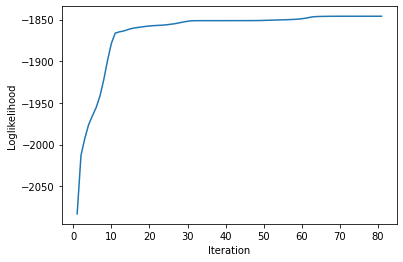

In [ ]:
gmm = EM(X,kkk)
W_p=gmm.fit()

Clustering 정확도 

In [ ]:
cluster_labels=clustering_accuracy(W_p,NUM,kkk)

clustering 된 라벨 [6 0 6 0 0 0 0 6 6 6 0 0 0 0 0 6 0 6 0 0 6 0 0 0 6 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Clustering accuracy is  0.8


최적화된 평균,분산, 알파, 분포 그래프.

After EM
mean
[[ 69.8 -19.6]
 [ 18.9  19.3]
 [ -1.9 -39. ]
 [ 80.1  40.5]
 [-22.5  16.1]
 [ 20.2 -20.8]
 [-19.7  19.3]]

coVariance
[[[ 1.647e+02 -2.018e+02]
  [-2.018e+02  4.877e+02]]

 [[ 3.370e+01 -1.000e-01]
  [-1.000e-01  3.810e+01]]

 [[ 6.150e+01 -6.000e-01]
  [-6.000e-01  3.810e+01]]

 [[ 6.370e+01 -8.000e-01]
  [-8.000e-01  3.560e+01]]

 [[ 1.060e+01 -1.570e+01]
  [-1.570e+01  2.370e+01]]

 [[ 5.460e+01 -9.500e+00]
  [-9.500e+00  6.050e+01]]

 [[ 5.910e+01  3.500e+00]
  [ 3.500e+00  5.260e+01]]]

alpha
[0.3 0.1 0.1 0.1 0.  0.2 0.1]



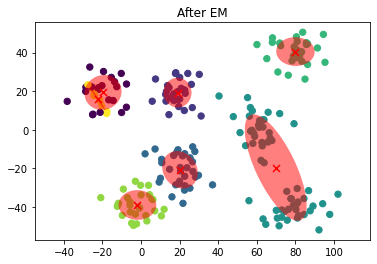

In [ ]:
draw_optimized_gaussian(X,cluster_labels,kkk)

## Different spherical covariance
 

원래 분포


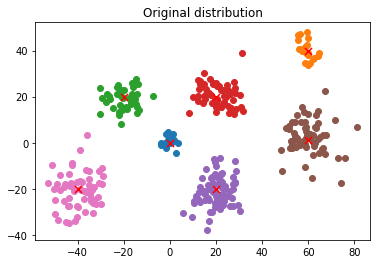


원래분포
mean
[[  0   0]
 [ 60  40]
 [-20  20]
 [ 20  20]
 [ 20 -20]
 [ 60   1]
 [-40 -20]]

coVariance
[[[ 5  0]
  [ 0  5]]

 [[10  0]
  [ 0 10]]

 [[20  0]
  [ 0 20]]

 [[30  0]
  [ 0 30]]

 [[40  0]
  [ 0 40]]

 [[50  0]
  [ 0 50]]

 [[60  0]
  [ 0 60]]]

alpha
[0.06 0.06 0.12 0.18 0.24 0.18 0.18]


In [ ]:

NUM= [20,20,40,60,80,60,60] #각 클래스 별 데이터 수. 
kkk=len(NUM) #class 갯수
Means=[ #각 class의 평균
     [-0, 0],
     [60, 40],
     [-20, 20],
     [20, 20],
     [20, -20],
     [60, 1],
     [-40, -20]]
COVS=[ #각 클래스 분산 
        [[5, 0], [0, 5]],
        [[10, 0], [0, 10]],
        [[20, 0], [0, 20]],
        [[30, 0], [0, 30]],
        [[40, 0], [0, 40]],
        [[50, 0], [0, 50]],
        [[60, 0], [0, 60]]]

X=Gausion_Mixture(kkk,NUM,Means,COVS)

EM 적용
- getting maximum loglikelihood
- getting optimized parameters

Iteration 5: log-likelihood is -2933.437806
Iteration 10: log-likelihood is -2873.414991
Iteration 15: log-likelihood is -2856.343578
Iteration 20: log-likelihood is -2784.243392
Iteration 25: log-likelihood is -2752.746427
Iteration 30: log-likelihood is -2737.723878

31-th쯤되면 loglikelihood 변화없네,log-likelihood is -2737.723874


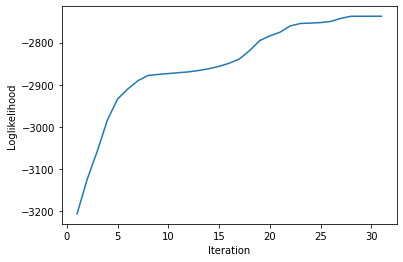

In [ ]:
gmm = EM(X,kkk)
W_p=gmm.fit()

Clustering 정확도 

In [ ]:
cluster_labels=clustering_accuracy(W_p,NUM,kkk)

clustering 된 라벨 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6]
Clustering accuracy is  0.997


After EM
mean
[[ 20.6  20.4]
 [ 58.   40.2]
 [-39.6 -20.7]
 [ 20.1 -20.9]
 [ 60.2   2.5]
 [-20.1  18.7]
 [ -0.3   0.6]]

coVariance
[[[33.  -7.6]
  [-7.6 19.1]]

 [[42.1 -3.7]
  [-3.7 16.6]]

 [[38.9  5. ]
  [ 5.  57. ]]

 [[25.8  7.7]
  [ 7.7 38.3]]

 [[45.6 -3.8]
  [-3.8 52.6]]

 [[26.4  1.9]
  [ 1.9 19.1]]

 [[ 3.3  0.1]
  [ 0.1  4.7]]]

alpha
[0.2 0.1 0.2 0.2 0.2 0.1 0.1]



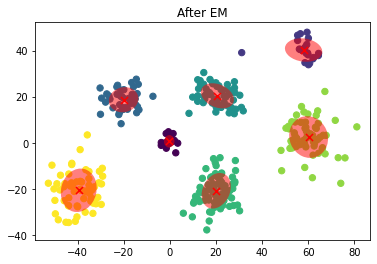

In [ ]:
draw_optimized_gaussian(X,cluster_labels,kkk)

## different diagonal covariance


원래 분포


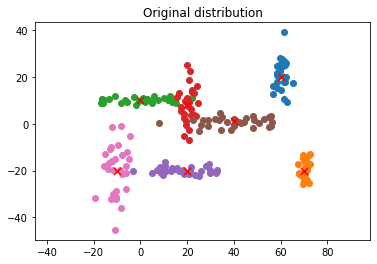


원래분포
mean
[[ 60  20]
 [ 70 -20]
 [  0  10]
 [ 20   8]
 [ 20 -20]
 [ 40   1]
 [-10 -20]]

coVariance
[[[  4   0]
  [  0  50]]

 [[  1   0]
  [  0  20]]

 [[100   0]
  [  0   1]]

 [[  5   0]
  [  0  80]]

 [[120   0]
  [  0   2]]

 [[100   0]
  [  0   5]]

 [[ 10   0]
  [  0  70]]]

alpha
[0.14 0.14 0.14 0.14 0.14 0.14 0.14]


In [ ]:

NUM= [30,30,30,30,30,30,30] #각 클래스 별 데이터 수. 
kkk=len(NUM) #class 갯수
Means=[ #각 class의 평균
     [60, 20],
     [70, -20],
     [-0, 10],
     [20, 8],
     [20, -20],
     [40, 1],
     [-10, -20]]
COVS=[ #각 클래스 분산 
         [[4, 0], [0, 50]],
        [[1, 0], [0, 20]],
      [[100, 0], [0, 1]],
        [[5, 0], [0, 80]],
        [[120, 0], [0, 2]],
        [[100, 0], [0, 5]],
        [[10, 0], [0, 70]]]

X=Gausion_Mixture(kkk,NUM,Means,COVS)

EM 적용
- getting maximum loglikelihood
- getting optimized parameters

Iteration 5: log-likelihood is -1706.034129
Iteration 10: log-likelihood is -1636.693394
Iteration 15: log-likelihood is -1636.032039
Iteration 20: log-likelihood is -1635.888209
Iteration 25: log-likelihood is -1635.861743
Iteration 30: log-likelihood is -1635.854038
Iteration 35: log-likelihood is -1635.850139
Iteration 40: log-likelihood is -1635.847167
Iteration 45: log-likelihood is -1635.844334
Iteration 50: log-likelihood is -1635.841471
Iteration 55: log-likelihood is -1635.838713
Iteration 60: log-likelihood is -1635.836365
Iteration 65: log-likelihood is -1635.834687
Iteration 70: log-likelihood is -1635.833698
Iteration 75: log-likelihood is -1635.833209
Iteration 80: log-likelihood is -1635.832997
Iteration 85: log-likelihood is -1635.832914

86-th쯤되면 loglikelihood 변화없네,log-likelihood is -1635.832905


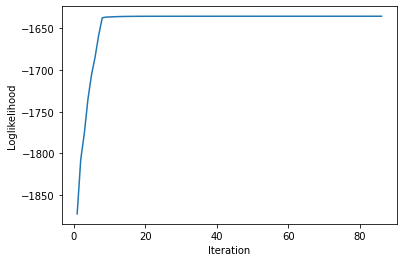

In [ ]:
gmm = EM(X,kkk)
W_p=gmm.fit()

Clustering 정확도 

In [ ]:
cluster_labels=clustering_accuracy(W_p,NUM,kkk)

clustering 된 라벨 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 2 2 2 5 2 2 2 2 5 5 2 5 2
 3 2 2 5 5 5 2 5 2 5 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 1 1 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Clustering accuracy is  0.8


최적화된 평균,분산, 알파, 분포 그래프.

After EM
mean
[[ 21.    7. ]
 [-10.4 -19.5]
 [ 55.6  -9.2]
 [-12.6   9.7]
 [ 60.3  21.4]
 [  6.2  10.5]
 [ 17.9 -19.9]]

coVariance
[[[   5.6   -0.9]
  [  -0.9   57.5]]

 [[  12.     5.3]
  [   5.3  108.9]]

 [[ 302.  -163.1]
  [-163.1  120.7]]

 [[  26.5   -2.2]
  [  -2.2    0.9]]

 [[   3.6    1.1]
  [   1.1   36.6]]

 [[  62.4   -1.9]
  [  -1.9    0.9]]

 [[  89.9   -1.2]
  [  -1.2    2. ]]]

alpha
[0.1 0.1 0.3 0.  0.1 0.1 0.1]



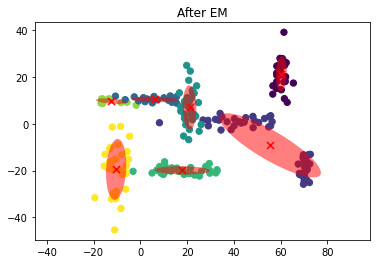

In [ ]:
draw_optimized_gaussian(X,cluster_labels,kkk)

## Arbitrary same covariance



원래 분포


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


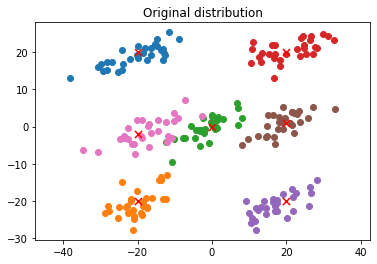


원래분포
mean
[[-20  20]
 [-20 -20]
 [  0   0]
 [ 20  20]
 [ 20 -20]
 [ 20   1]
 [-20  -2]]

coVariance
[[[10 10]
  [30 10]]

 [[10 10]
  [30 10]]

 [[10 10]
  [30 10]]

 [[10 10]
  [30 10]]

 [[10 10]
  [30 10]]

 [[10 10]
  [30 10]]

 [[10 10]
  [30 10]]]

alpha
[0.14 0.14 0.14 0.14 0.14 0.14 0.14]


In [ ]:
NUM= [30,30,30,30,30,30,30] #각 클래스 별 데이터 수. 
kkk=len(NUM)
Means=[ #각 class의 평균
    [-20, 20],
    [-20, -20],
    [0, 0],
    [20, 20],
    [20, -20],
    [20, 1],
    [-20, -2]]

COVS=[ #각 클래스 분산 
      [[10, 10], [30, 10]],
      [[10, 10], [30, 10]],
      [[10, 10], [30, 10]],
      [[10, 10], [30, 10]],
      [[10, 10], [30, 10]],
      [[10, 10], [30, 10]],
      [[10, 10], [30, 10]]]

X=Gausion_Mixture(kkk,NUM,Means,COVS)

EM 적용
- getting maximum loglikelihood
- getting optimized parameters

Iteration 5: log-likelihood is -1625.293684
Iteration 10: log-likelihood is -1568.484632
Iteration 15: log-likelihood is -1557.674302
Iteration 20: log-likelihood is -1553.160840
Iteration 25: log-likelihood is -1534.170641
Iteration 30: log-likelihood is -1532.796837
Iteration 35: log-likelihood is -1532.796690

35-th쯤되면 loglikelihood 변화없네,log-likelihood is -1532.796690


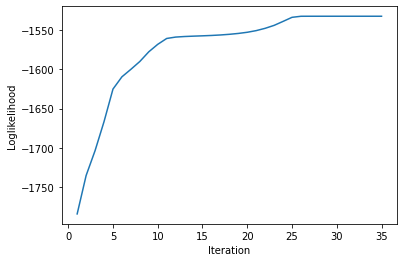

In [ ]:
gmm = EM(X,kkk)
W_p=gmm.fit()

Clustering 정확도 

In [ ]:
cluster_labels=clustering_accuracy(W_p,NUM,kkk)

clustering 된 라벨 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 2 2 6 6 6 2 6 6 6 6 6 6 6
 2 6 6 6 6 6 2 6 2 6 6 6 6 6 6 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Clustering accuracy is  0.881


최적화된 평균,분산, 알파, 분포 그래프.

After EM
mean
[[-19.7 -20.3]
 [ 21.1  20.9]
 [ 17.2 -21.2]
 [-10.6  -1.1]
 [-20.3  19. ]
 [  2.9   3. ]
 [ 19.3   0.9]]

coVariance
[[[ 22.5  11.1]
  [ 11.1  15.3]]

 [[ 42.2   8.8]
  [  8.8   5.6]]

 [[ 27.8  10.5]
  [ 10.5   8.7]]

 [[105.5  16.3]
  [ 16.3   9.7]]

 [[ 48.1  16.5]
  [ 16.5   8.5]]

 [[ 41.4  29.9]
  [ 29.9  21.9]]

 [[ 25.2  10.1]
  [ 10.1   8.5]]]

alpha
[0.1 0.1 0.1 0.3 0.1 0.  0.1]



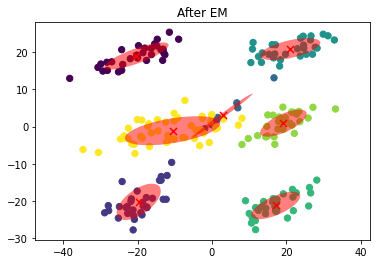

In [ ]:
draw_optimized_gaussian(X,cluster_labels,kkk)

## Arbitrary covariance
- 5 Gaussians


원래 분포


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


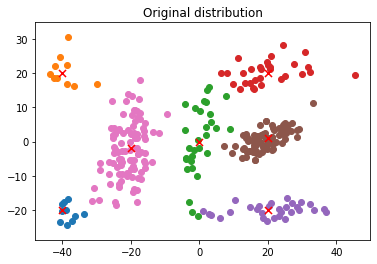


원래분포
mean
[[-40 -20]
 [-40  20]
 [  0   0]
 [ 20  20]
 [ 20 -20]
 [ 20   1]
 [-20  -2]]

coVariance
[[[  3   4]
  [-10  11]]

 [[ -1  19]
  [ 20   9]]

 [[ 16  10]
  [ 10 100]]

 [[ 50   7]
  [  1   7]]

 [[ 10   4]
  [ 70   6]]

 [[ 10  10]
  [ 30  10]]

 [[ 10  70]
  [ 20  26]]]

alpha
[0.03 0.03 0.1  0.1  0.1  0.28 0.34]


In [ ]:
NUM= [10,10,30,30,30,80,100] #각 클래스 별 데이터 수. 
kkk=len(NUM)
Means=[ #각 class의 평균
    [-40, -20],
    [-40, 20],
    [0, 0],
    [20, 20],
    [20, -20],
    [20, 1],
    [-20, -2]]

COVS=[ #각 클래스 분산 
      [[3, 4], [-10, 11]],
      [[-1, 19], [20, 9]],
      [[16, 10], [10, 100]],
      [[50, 7], [1, 7]],
      [[10, 4], [70, 6]],
      [[10, 10], [30, 10]],
      [[10, 70], [20, 26]]]

X=Gausion_Mixture(kkk,NUM,Means,COVS)

EM 적용
- getting maximum loglikelihood
- getting optimized parameters

Iteration 5: log-likelihood is -2321.530919
Iteration 10: log-likelihood is -2304.579038
Iteration 15: log-likelihood is -2261.312322
Iteration 20: log-likelihood is -2200.089548
Iteration 25: log-likelihood is -2197.351111
Iteration 30: log-likelihood is -2192.821735
Iteration 35: log-likelihood is -2183.725529
Iteration 40: log-likelihood is -2183.627405
Iteration 45: log-likelihood is -2183.591546
Iteration 50: log-likelihood is -2183.569110
Iteration 55: log-likelihood is -2183.548621
Iteration 60: log-likelihood is -2183.521317
Iteration 65: log-likelihood is -2183.469675
Iteration 70: log-likelihood is -2183.321375
Iteration 75: log-likelihood is -2182.280996
Iteration 80: log-likelihood is -2180.565553
Iteration 85: log-likelihood is -2180.559200
Iteration 90: log-likelihood is -2180.554766
Iteration 95: log-likelihood is -2180.552756
Iteration 100: log-likelihood is -2180.552128
Iteration 105: log-likelihood is -2180.551940
Iteration 110: log-likelihood is -2180.551871

110-th쯤

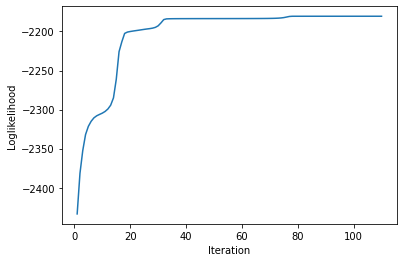

In [ ]:
gmm = EM(X,kkk)
W_p=gmm.fit()

Clustering 정확도 

In [ ]:
cluster_labels=clustering_accuracy(W_p,NUM,kkk)

clustering 된 라벨 [6 6 6 6 6 6 6 6 6 6 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 4 2 2 4 0 0 2 2 0 0 3
 0 2 3 4 2 0 0 2 2 2 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Clustering accuracy is  0.91


최적화된 평균,분산, 알파, 분포 그래프.

After EM
mean
[[-22.3  -4.1]
 [ -1.6  -3.7]
 [ 18.9 -20. ]
 [ 18.2  19.7]
 [  2.3   7.5]
 [ 19.1   0.7]
 [-39.4  20.7]]

coVariance
[[[ 41.7  36.5]
  [ 36.5  86.1]]

 [[  4.1   2.6]
  [  2.6  13.3]]

 [[126.    3.4]
  [  3.4   2.7]]

 [[ 87.4  16. ]
  [ 16.   12.6]]

 [[ 11.2  -7.9]
  [ -7.9  11.2]]

 [[ 23.3   9.2]
  [  9.2   9.1]]

 [[ 13.8  -3.5]
  [ -3.5  17.5]]]

alpha
[0.4 0.  0.1 0.1 0.  0.3 0. ]



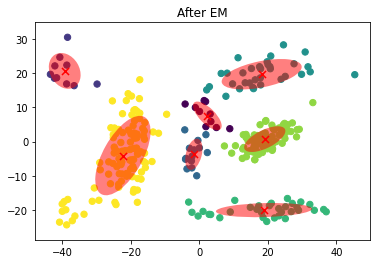

In [ ]:
draw_optimized_gaussian(X,cluster_labels,kkk)